# Лабораторная работа 1. Метод обратного распространения ошибки.
## Выполнил: Уткин Г.В. (гр. 3823М1ПМкн)

## Задачи работы
Выполнение работы предполагает решение следующих задач:
1. Изучение общей схемы работы метода обратного распространения ошибки с помощью стохастического градиентного спуска.
2. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Реализация и тестирование метода обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST.

Конфигурация нейронной сети:
1. Входной слой содержит $w \times h$ нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет $28 \times 28$).
2. Выходной слой содержит $k$ нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – $10$ классов).
3. Скрытый слой содержит $s$ нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от $8$ до $64$ изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - $0.1.$
    - Количество скрытых нейронов $s$ - $300.$
    - Количество эпох – $20.$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Размеры тренировочных данных. train_images:  (60000, 28, 28) , train_labels:  (60000,)
Размеры тестовых данных. test_images:  (10000, 28, 28) , test_labels:  (10000,)


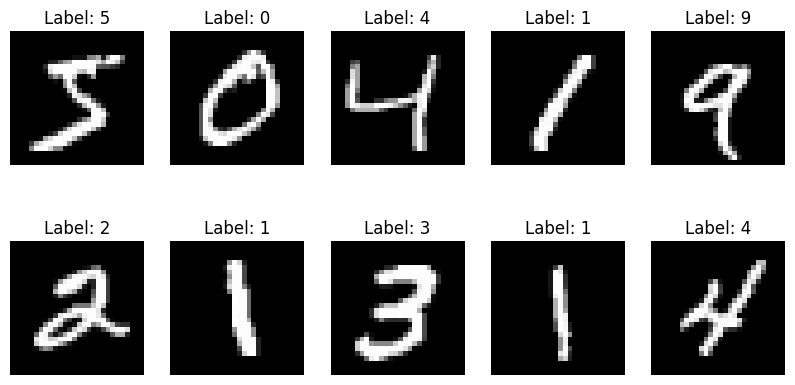

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)  
        images = np.fromfile(f, dtype=np.uint8)
        images = images / 255.0
        images = images.reshape(-1, 28, 28)
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

train_images = load_mnist_images('archive/train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = load_mnist_labels('archive/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = load_mnist_images('archive/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('archive/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
print("Размеры тренировочных данных. train_images: ", train_images.shape, ", train_labels: ", train_labels.shape)
print("Размеры тестовых данных. test_images: ", test_images.shape, ", test_labels: ", test_labels.shape)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {train_labels[i]}')  
    plt.axis('off')

plt.show()

In [3]:
class neural_network:
    def __init__(self, inputs, hiddens, outputs, lr):
        self.inputs_count = inputs
        self.hiddens_count = hiddens
        self.output_count = outputs
        self.lr = lr

        # Инициализация весов. Вес от входного к скрытому.
        self.W1 = np.random.randn(self.inputs_count, self.hiddens_count) * np.sqrt(2.0/self.inputs_count)
        # Инициализация весов. Вес от скрытого к выходному.
        self.W2 = np.random.randn(self.hiddens_count, self.output_count) * np.sqrt(2.0/self.hiddens_count)

        # Смещения
        self.b1 = np.zeros((1, self.hiddens_count)) # Для скрытого слоя
        self.b2 = np.zeros((1, self.output_count)) # Для выходного слоя
    
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1  # Линейная часть скрытого слоя
        self.A1 = self.ReLU(self.Z1)  
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # Линейная часть выходного слоя
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def backward(self, X, y, output):
        m = X.shape[0]

        # Вычисление ошибки на выходном слое
        delta2 = output # output результат softmax из forward.
        delta2[range(m), y] -= 1  # Ошибка выхода, вычитаем 1 от правильного класса
        delta2 /= m  # Среднее значение ошибки
        # Градиенты для W2 и b2
        dW2 = np.dot(self.A1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)

        # Ошибка на скрытом слое
        delta1 = np.dot(delta2, self.W2.T) * self.dReLU(self.Z1)

        # Градиенты для W1 и b1
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Обновление весов с использованием градиентного спуска
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
    
    def train(self, X_train, y_train, X_test, y_test, epochs, batch_size):
        for epoch in range(epochs):
            indices = np.random.permutation(X_train.shape[0]) # Перемешка данных
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train_shuffled[i:i + batch_size] # Получаем мини-пачки данных
                y_batch = y_train_shuffled[i:i + batch_size]

                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output)

            predictions = self.forward(X_train)
            loss = self.cross_entropy_loss(predictions, y_train)
            acc = self.accuracy(X_train, y_train)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}, Accuracy: {acc}')

        test_acc = self.accuracy(X_test, y_test)
        test_output = self.forward(X_test)
        test_loss = self.cross_entropy_loss(test_output, y_test)
        print(f'Результат на тестовой выборке: loss: {test_loss}, accuracy: {test_acc}')
    
    def ReLU(self, x):
        return np.maximum(0, x)

    def dReLU(self, x):
        return np.where(x > 0, 1, 0)
        
    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis = 1, keepdims = True))
        return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

    def predict(self, x):
        output = self.forward(x)
        return np.argmax(output, axis=1)

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def cross_entropy_loss(self, predictions, labels):
        m = labels.shape[0]
        log_likelihood = -np.log(predictions[range(m), labels])
        loss = np.sum(log_likelihood) / m
        return loss


In [4]:
input_size = 28 * 28  
hidden_size = 300  
output_size = 10  
learning_rate = 0.1
epochs = 20
batch_size = 32

train_images = train_images.reshape(-1, 28 * 28)  # изображения в вектор
test_images = test_images.reshape(-1, 28 * 28)


nn = neural_network(input_size, hidden_size, output_size, learning_rate)

nn.train(train_images, train_labels, test_images, test_labels, epochs, batch_size)

Epoch 1/20, Loss: 0.15687421634558546, Accuracy: 0.9547833333333333
Epoch 2/20, Loss: 0.09831966451116328, Accuracy: 0.9732666666666666
Epoch 3/20, Loss: 0.0731616548892151, Accuracy: 0.9799
Epoch 4/20, Loss: 0.05658967775554924, Accuracy: 0.98545
Epoch 5/20, Loss: 0.047776365958919306, Accuracy: 0.9877
Epoch 6/20, Loss: 0.03914728141842508, Accuracy: 0.9900166666666667
Epoch 7/20, Loss: 0.03127115142352095, Accuracy: 0.9922833333333333
Epoch 8/20, Loss: 0.027422969728342506, Accuracy: 0.9929833333333333
Epoch 9/20, Loss: 0.023360415142140566, Accuracy: 0.9945
Epoch 10/20, Loss: 0.020716418915665013, Accuracy: 0.9956333333333334
Epoch 11/20, Loss: 0.017263880300909723, Accuracy: 0.9967
Epoch 12/20, Loss: 0.01432147156830029, Accuracy: 0.9978166666666667
Epoch 13/20, Loss: 0.013612013330310466, Accuracy: 0.9979333333333333
Epoch 14/20, Loss: 0.009868958100116154, Accuracy: 0.9990666666666667
Epoch 15/20, Loss: 0.009045232242868309, Accuracy: 0.9991166666666667
Epoch 16/20, Loss: 0.00841